In [3]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt
import glob
import librosa
%matplotlib inline

In [4]:
audio_path = "/data/home/vvaibhav/Internship/Heart/the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data/"
audio_files = glob.glob(audio_path + "/*.wav")
print(len(audio_files))
audio_file = audio_files[0]
print(audio_file)

3163
/data/home/vvaibhav/Internship/Heart/the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data/50782_AV_2.wav


In [5]:
ipd.Audio(audio_file)

In [6]:
#by default librosa will normalize the data no need to normalize further 
audio, sr = librosa.load(audio_file, sr = 44100)
print(len(audio), sr)
duration = len(audio) / sr
print(duration, "sec")


848837 44100
19.24800453514739 sec


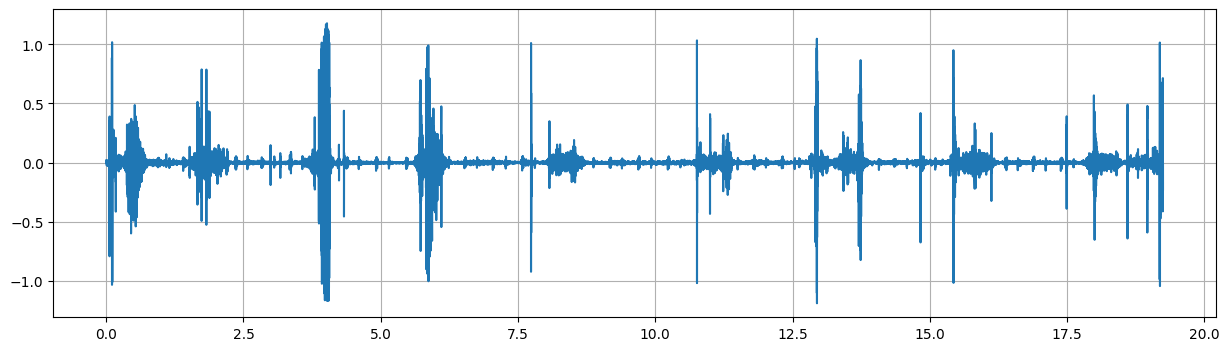

In [7]:
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sr, num=len(audio)), audio)
plt.grid(True)

In [11]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))

    # print(len(frames))
    # print(frame_len)
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

In [12]:
hop_size = 15 #ms
FFT_size = 2048

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sr)
print("Framed audio shape: {0}".format(audio_framed.shape))

1283
662
Framed audio shape: (1283, 2048)


In [16]:
print("First frame:")
audio_framed[1]

First frame:


array([0.00634488, 0.00634929, 0.00640828, ..., 0.00410162, 0.00414432,
       0.00423312])

In [17]:
print("Last frame:")
audio_framed[-1]

Last frame:


array([-0.02325499, -0.02180894, -0.0203673 , ..., -0.02442497,
       -0.02433016, -0.02409111])

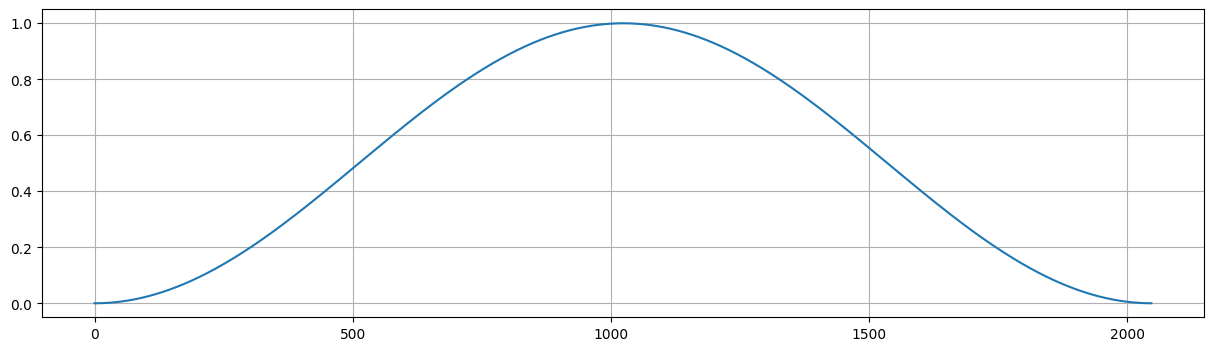

In [18]:
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

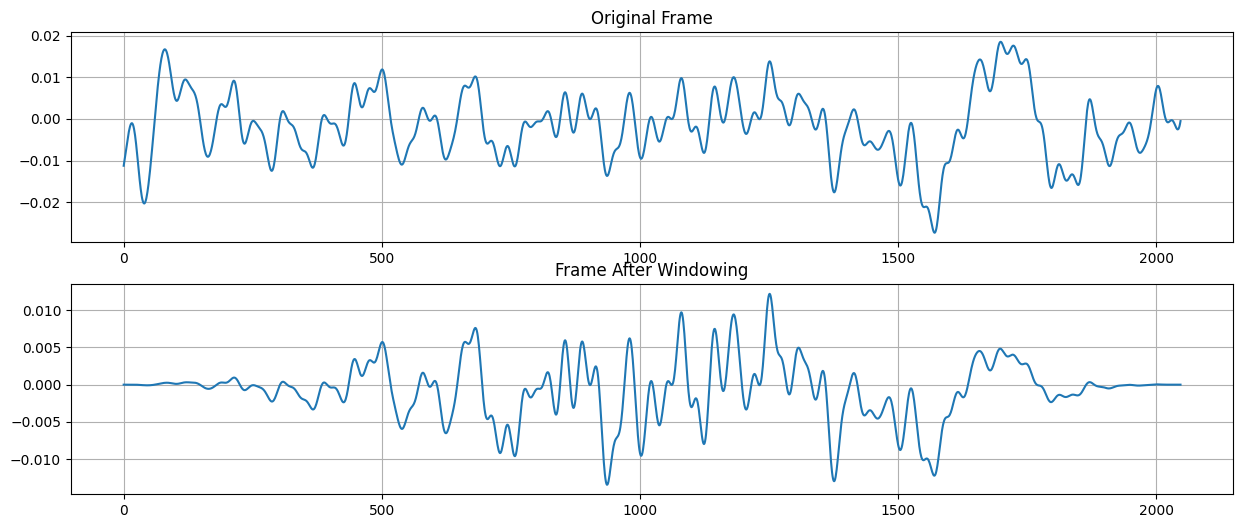

In [19]:
audio_win = audio_framed * window

ind = 69
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

In [20]:
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

In [21]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(1283, 1025)


In [22]:
freq_min = 0
freq_high = sr / 2
mel_filter_num = 10

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 22050.0


In [23]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [24]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [25]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)
print(filter_points)
print(mel_freqs)

MEL min: 0.0
MEL max: 3923.337321740179
[   0   12   28   51   82  125  184  265  376  528  737 1024]
[    0.           260.59867204   618.21401246  1108.96375691
  1782.4116895   2706.57338913  3974.785534    5715.13253718
  8103.38256596 11380.73943188 15878.20322216 22050.        ]


In [46]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

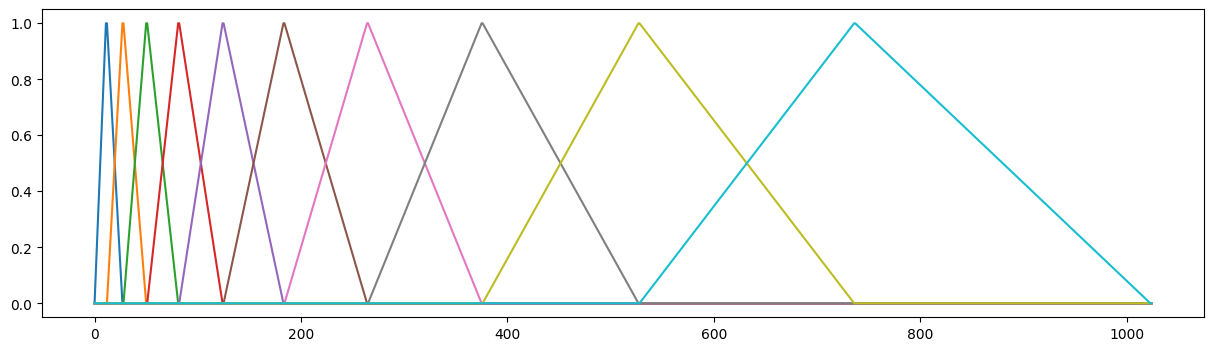

In [47]:
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [48]:
# taken from the librosa library
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

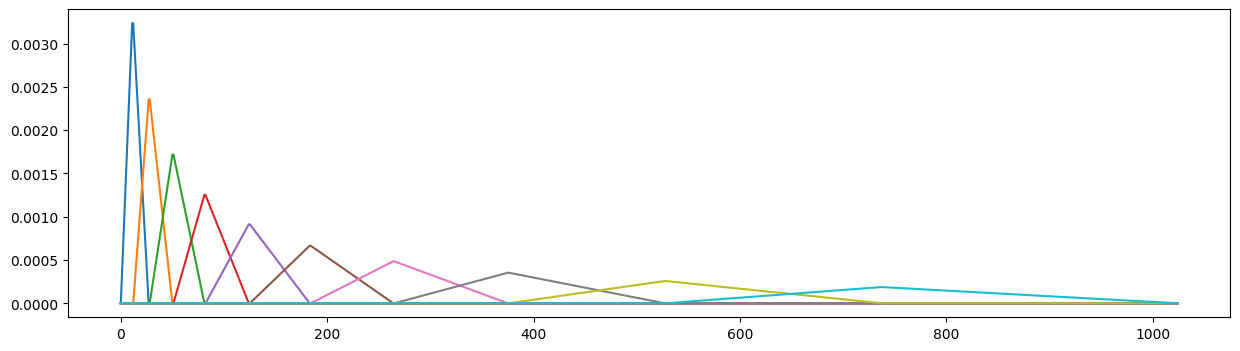

In [49]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [50]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

(10, 14148)

In [51]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [52]:
dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(40, 14148)

In [53]:
cepstral_coefficents[:, 0]

array([-1.52526611e+02,  7.06637517e+01,  1.38045737e+01,  3.02343378e+00,
       -3.21755525e+00,  4.05943855e+00,  4.04702583e+00,  5.62586998e-01,
       -1.78652437e+00, -1.45030357e+00,  2.91968275e-13,  1.45030357e+00,
        1.78652437e+00, -5.62586998e-01, -4.04702583e+00, -4.05943855e+00,
        3.21755525e+00, -3.02343378e+00, -1.38045737e+01, -7.06637517e+01,
        2.15705202e+02, -7.06637517e+01, -1.38045737e+01, -3.02343378e+00,
        3.21755525e+00, -4.05943855e+00, -4.04702583e+00, -5.62586998e-01,
        1.78652437e+00,  1.45030357e+00, -1.38118694e-13, -1.45030357e+00,
       -1.78652437e+00,  5.62586998e-01,  4.04702583e+00,  4.05943855e+00,
       -3.21755525e+00,  3.02343378e+00,  1.38045737e+01,  7.06637517e+01])

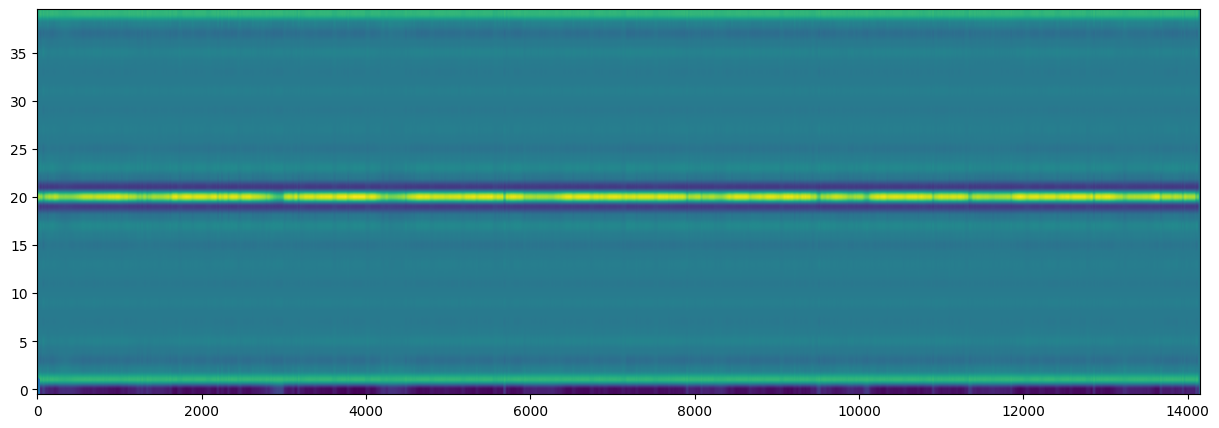

In [55]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sr, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');